## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction<a name="introduction"></a>

Hanami ("flower viewing") is the traditional custom of viewing and enjoying the beauty of flowers, mainly cherry blossoms, and springtime in Japan. Each year the "cherry blossom front", the advance of blooming of cherry blossoms across Japan, is tracked as it slowly moves northward. The front generally indicates the opening of the first blossoms (kaika) rather than the arrival of full bloom (mankai). Forecasts for the cherry blossom front by are closely followed by those who wish to enjoy hanami as the blossoms only last for one to two weeks. 

To enjoy Hanami, one can admire from a distance in which the cherry blossoms have been described as appearing as beautiful clouds, have a picnic under the blooming trees, or take a nice stroll in a park after enjoying a nice meal such as a bowl of Ramen. 

While the exact origins of ramen noodles is up to debate (Japan or China origin), what is not up for debate is how Ramen shops across Japan have really made Ramen their own. As the name suggest, Ramen shops specialize in ramen dishes. Ramen in simple terms are wheat-flour noodles served in broth. But Ramen is anything but simple. With over more than 10,000 ramen shops in Japan, each shop provides a different take on the dish of Ramen. 

In this project, we will try to find the best locations in Japan in which to enjoy both Hanami and Ramen from **April 15th to May 15th**. Best in this instance, refers to how easily a person can travel to the locations (i.e **promixity to train station**), **Hanami spots**, and **Ramen shops**. 

Note: Hanami Spots and Viewing Spots are used interchangeably throughout the project.

## Data <a name="data"></a>

With the criteria mention in the Introduction, factors that will influence our decision are:
* Timing of cherry blossoming in the city
* Proximity to a train station
* Recommended Cherry Blossom viewing spots (Hanami) spots, if any
* Ramen shops located close to the recommended Hanami spots

Following data sources will be needed to extract/generate the required information:
* Average Cherry Blossoms blooming dates using data gathered from: [https://www.japan-guide.com/e/e2011_when.html](https://www.japan-guide.com/e/e2011_when.html).
* Recommended Cherry Blossom viewing spots gathered from: [https://www.japan-guide.com/e/e2011_where.html](https://www.japan-guide.com/e/e2011_where.html) 
* **Google Places API** will be used to obtain the coordinates of each recommended viewing spot. The coordinates will be used to obtain the prefecture and region each of the recommended viewing spots are located within, this will be accomplished with the use of wikipedia.
* Ramen shops and Train stations around each recommended Hanami spot will be obtain using the **Foursquare API**

With the data collected, we hope to find locations that will be able satisfy a persons needs of enjoying the beauty of cherry blossoms and a bowl of delicious Ramen while being able to hop on a train. 

In [1]:
import os
from bs4 import BeautifulSoup as BS
import requests
import re
import csv
import json
import creds
import numpy as np
import folium
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering 

import pandas as pd 
pd.set_option('display.max_colwidth', None)
pd.set_option('colheader_justify', 'left')
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
%matplotlib inline

import io
from PIL import Image


dataFolder = './data/'
imgFolder = './images/'

In [2]:
def get_html_object(html_page, soup_object, print_output):
    
    '''
    The webpage is scrapped and saved to either a BeautifulSoup object or into a pandas dataframe.
    - BeautifulSoup object when data is not in a table on the website. More processing will be done 
    with returned object to get desired data.
    
    - pandas dataframe when the data is located within a table.
    
    Saves scrapped information to local directory if data not previously scrapped. Opens local file
    if website previously scrapped instead of rescrapping website.
    '''
    html_file = "{}{}.html".format(dataFolder, html_page.replace('https://','').replace('/','-'))
    
    if os.path.exists(html_file):
        with open(html_file, 'rb') as html:
            html_content = html.read()   
    else:
        html_content = requests.get(html_page).text
        with open(html_file, 'wb') as file:
            page = bytes(html_content, 'utf-8')
            file.write(page)
    
    if soup_object:
        return_object = BS(html_content, 'lxml')
    else:
        x = pd.read_html(html_file,header=0)
        
        return_object = x
    
    if print_output:
        print(f'Returned object type: {type(return_object)}')    
    return return_object

def clean_headers(df):
    '''
    Standardize headers of dataframes
    '''
    df.columns = df.columns.str.upper().str.replace(r'\W+','_',regex=True)
    return df

### Average Cherry Blossoms blooming dates

Let's begin by obtaining the typical timing for the blooming of cherry blossoms in cities across Japan. 

We can obtain Average Cherry Blossoms blooming dates from [https://www.japan-guide.com/e/e2011_when.html](https://www.japan-guide.com/e/e2011_when.html).

The data is contained within a table on the webpage, meaning the data can be read directly into a pandas dataframe. 

Only the cities which are typically in full bloom from April 15th to May 15th will be stored within `averageBlooming_df`

In [3]:
averageBlooming_df = get_html_object('https://www.japan-guide.com/e/e2011_when.html', 0, 0)[0]
averageBlooming_df = clean_headers(averageBlooming_df)

df = pd.to_datetime(averageBlooming_df['AVERAGE_FULL_BLOOM'],format='%B %d')
mask = (df >= '1900-04-15') & (df<= '1900-05-30') # dummy year
averageBlooming_df = averageBlooming_df.loc[mask]

averageBlooming_df

,CITY,AVERAGE_OPENING,AVERAGE_FULL_BLOOM
0,Sapporo,May 3,May 7
1,Hakodate,April 30,May 4
2,Hirosaki,April 23,April 28
3,Sendai,April 11,April 16
7,Matsumoto,April 10,April 15
8,Takayama,April 15,April 20


### Cherry Blossom Viewing Spots

Recommendations for the best cherry blossom viewing spots (Hanami Spots) can be found at [https://www.japan-guide.com/e/e2011_where.html](https://www.japan-guide.com/e/e2011_where.html).

The information for the different Cherry Blossom Viewing Spots will be scraped using a BeautifulSoup object.

Infomation to be obtained for each spot will be:

* City
* Viewing Spot
* Description
* Ratings
* Ratings Description

In [4]:
viewing_soup = get_html_object("https://www.japan-guide.com/e/e2011_where.html", 1, 0)
viewing_cities = [city.text for city in viewing_soup.select('h3')]
viewing_spots = []

for city, section in zip(viewing_cities, viewing_soup.select('section.spot_list')):
    spot_descriptions = iter(section.select('.spot_list__spot__desc'))
    for spot in section.select('.spot_list__spot__name'):
        cell = {}
        cell['City'] = city
        cell['Viewing_Spot'] = re.sub(r'[^\w\s]+', '', spot.text) # removes all dots from end of string
        cell['Description'] = next(spot_descriptions).text.replace('\n','').replace('\r','')
        if spot.find('span', class_='dot_rating has-tooltip'):
            cell['Rating'] = spot.find('span', class_='dot_rating has-tooltip')['data-dots']
            cell['Rating_Description'] = spot.find('span', class_='dot_rating has-tooltip')['data-tooltip-label']
        else:
            cell['Rating'] = ''
            cell['Rating_Description'] = 'No Rating'
        viewing_spots.append(cell)
        
viewingSpot_df = clean_headers(pd.DataFrame(viewing_spots))

print(f'Number of "Best" viewing spots across Japan : {viewingSpot_df.shape[0]}.')

Number of "Best" viewing spots across Japan : 48.


#### Obtaining geographical information for the recommended Viewing Spots

The `CITY` column in `viewingSpot_df` contains some values which aren't exactly cities. 

We will use reverse geocoding to obtain the geographical information for each of the viewing spots to determine the city, prefecture, coordinates for each of the viewing spots. The information will be saved to a local csv file to keep from needing to make future calls to the Google Api.

In [5]:
csvName = f'{dataFolder}{"viewingspots_coords.csv"}'

def get_coords(name, details):
    ''' Makes a call to the Google Api using the name of the location. Japan is appended to the name to avoid 
    any misassociation with a location located in different part of the world besides Japan. 
    
        The first api call obtains the coordinates and the unique [place_id] for each location.
        
        A second call is made to a different endpoint with the obtained [place_id] in order to grab the City and 
        Prefecture of the location.  
        
        Saves data to local csv to prevent calling google api over and over. Local csv is loaded if file exists.
    '''
    name1 = f'{name}, Japan'
    inital_call = f'Making call to googleapi for {name1}....'
    url = f'https://maps.googleapis.com/maps/api/place/findplacefromtext/json?key={creds.Places_Key}&input={name1}&inputtype=textquery&fields={details}'
    response = requests.get(url).json()
    if (response['status'] == 'OK'):
        print(f'{inital_call}Valid location found...Collecting details...')
        lat = response['candidates'][0]['geometry']['location']['lat']
        lon = response['candidates'][0]['geometry']['location']['lng']
        place_id = response['candidates'][0]['place_id']
        url2 = f'https://maps.googleapis.com/maps/api/place/details/json?key={creds.Places_Key}&place_id={place_id}&fields=address_components'
        response2 = requests.get(url2).json()
        city = [x['long_name'] for x in response2['result']['address_components'] if x['types'][0] == 'locality'][0]
        pref = [x['long_name'] for x in response2['result']['address_components'] if x['types'][0] == 'administrative_area_level_1'][0]
    else:
        name2 = f'{name}'
        print(f'{inital_call}\n -----No valid location found...Trying call with {name2}...')
        url = f'https://maps.googleapis.com/maps/api/place/findplacefromtext/json?key={creds.Places_Key}&input={name2}&inputtype=textquery&fields={details}'
        response = requests.get(url).json()
        if (response['status'] == 'OK'):
            print(f'-----{name2} Valid location found...Collecting details...')
            lat = response['candidates'][0]['geometry']['location']['lat']
            lon = response['candidates'][0]['geometry']['location']['lng']
            place_id = response['candidates'][0]['place_id']
            url2 = f'https://maps.googleapis.com/maps/api/place/details/json?key={creds.Places_Key}&place_id={place_id}&fields=address_components'
            response2 = requests.get(url2).json()
            city = [x['long_name'] for x in response2['result']['address_components'] if x['types'][0] == 'locality'][0]
            pref = [x['long_name'] for x in response2['result']['address_components'] if x['types'][0] == 'administrative_area_level_1'][0]
        else:
            print(f'*****{name2}: VALID LOCATION NOT FOUND*****')
            lat, lon, city, pref = np.nan, np.nan, np.nan, np.nan
    return city, pref, lat, lon


if not os.path.exists(csvName): # checks to see if local csv with coordinates is already available in local directory
    return_details = 'place_id,geometry'
    coordinates_list = []
    for viewingSpot in viewingSpot_df['Viewing_Spot']:
        city, pref, lat, lon = get_coords(viewingSpot, return_details)
        coordinates_list.append([viewingSpot, city, pref, lat, lon])      
    cols = ['VIEWING_SPOT','CITY','PREFECTURE','LATITUDE','LONGITUDE',]    
    viewingSpot_coords = pd.DataFrame(coordinates_list,columns = cols)
    
    # saves the coordinates to local csvfile to stop future calls to Google
    viewingSpot_coords.to_csv(csvName,index=False)
    del return_details, coordinates_list, viewingSpot, lat, lon, cols
    
viewingSpot_coords = clean_headers(pd.read_csv(csvName))

#### Finding the prefecture and region for each of the locations within `viewingSpot_df`. 

We will now use the geographical information to find which region each of the viewing spots are within. This will be accomplished with a table obtain from [wikipedia](https://simple.wikipedia.org/wiki/Prefectures_of_Japan) which list each prefecture with corresponding region. 

The data is cleaned...all accents are stripped from the table entries. 

The data is then placed into a dict, japan_dict.

In [6]:
def strip_accents(text_list):
    '''
    Looks through provided list to remove any accents and non alpha characters
    '''
    import unicodedata
    lst = []
    for itext, txt in enumerate(text_list):
        try:
            text = unicode(txt, 'utf-8')
        except NameError: # unicode is a default on python 3 
            pass
        text = unicodedata.normalize('NFD', txt)\
               .encode('ascii', 'ignore')\
               .decode("utf-8")
        text = re.sub(r'[\W0-9]+','', text) # removes all non letter characters
        lst.append(text)
    return lst

japan_pref=get_html_object('https://simple.wikipedia.org/wiki/Prefectures_of_Japan', 0, 0)[1]
japan_pref=japan_pref[['Prefecture','Region']]
pref = strip_accents(japan_pref['Prefecture'])
region = strip_accents(japan_pref['Region'])

japan_dict = dict(zip(pref,region))

The region for each viewing spot will be obtained through the use of `japan_dict`. 

The `viewingSpot_df` will be updated to include a more accurate `CITY` column as well as columns for `PREFECTURE`, `REGION`, `LATITUDE`, and `LONGITUDE` for each of the recommended viewing locations.

In [7]:
city_col = []
pref_col = []
region_col = []

for ispot, row in viewingSpot_coords.iterrows():
    city_col.append(row.CITY)
    row_pref = row.PREFECTURE
    pref_col.append(row_pref)
    region_col.append(japan_dict[row_pref])

viewingSpot_df['CITY'] = city_col
viewingSpot_df['PREFECTURE'] = pref_col
viewingSpot_df['REGION'] = region_col
viewingSpot_df['LATITUDE'] = viewingSpot_coords.LATITUDE
viewingSpot_df['LONGITUDE'] = viewingSpot_coords.LONGITUDE

col_order = ['VIEWING_SPOT', 'CITY', 'PREFECTURE','REGION', 'LATITUDE','LONGITUDE','DESCRIPTION','RATING','RATING_DESCRIPTION']
viewingSpot_df = viewingSpot_df[col_order]

#### Lastly, only will focus on the viewing spots that are located within cities listed in the `averageBlooming_df`. 

The columns will be reorder to list the viewing spot first.

In [8]:
df = averageBlooming_df.merge(viewingSpot_df,on='CITY')

cols = list(df.columns)

a, b = cols.index('CITY'), cols.index('VIEWING_SPOT')
cols[b], cols[a] = cols[a], cols[b]

viewingSpot_df = df[cols]
viewingSpot_df

print(f'Number of recommended viewing spots from April 15th to May 15th: {viewingSpot_df.shape[0]}')
viewingSpot_df

Number of recommended viewing spots from April 15th to May 15th: 5


,VIEWING_SPOT,AVERAGE_OPENING,AVERAGE_FULL_BLOOM,CITY,PREFECTURE,REGION,LATITUDE,LONGITUDE,DESCRIPTION,RATING,RATING_DESCRIPTION
0,Maruyama Park and Hokkaido Shrine,May 3,May 7,Sapporo,Hokkaido,Hokkaido,43.055745,141.312607,"The park and the shrine are located just beside each other and attract some of the largest crowds for hanami parties in Sapporo. The approach to the shrine is lined with dozens of cherry trees, while the park areas offer a lot of open space where people lay out mats and enjoy food and drink with friends under the flowers.",1,Recommended
1,Goryokaku Fort,April 30,May 4,Hakodate,Hokkaido,Hokkaido,41.794670,140.754020,"Fort Goryokaku is a star shaped, Western style citadel which was built in Hakodate towards the end of the Edo Period. After the fort lost its military importance, it was eventually turned into a public park, and over one thousand cherry trees were planted along its moats, making it arguably Hokkaido's most famous cherry blossom spot.",2,Highly Recommended
2,Hirosaki Castle,April 23,April 28,Hirosaki,Aomori,Tohoku,40.607452,140.464180,"With its abundance of over 2500 trees, cherry blossom tunnels, petal filled moats, numerous pleasant picnic areas, rental rowing boats, many varieties of cherry trees and illuminations in the evenings, the park around Hirosaki Castle feels like multiple great cherry blossom spots combined into a single one.",3,Best of Japan
3,Mikamine Park,April 11,April 16,Sendai,Miyagi,Tohoku,38.224822,140.857414,"Located south of central Sendai, Mikamine Park is a spacious public park with hundreds of large, beautiful cherry trees and wide lawns, offering plenty of space to hold cherry blossom viewing parties underneath its cherry trees.",1,Recommended
4,Matsumoto Castle,April 10,April 15,Matsumoto,Nagano,Chubu,36.238653,137.968867,Matsumoto Castle is one of the most beautiful of Japan's original castles. There are about 300 cherry trees planted around the castle moats and inside the paid inner grounds of the castle.,2,Highly Recommended


### Get venues near Recommended Viewing Spots

Will search for Ramen shops and Train Stations within a 1.25 mile (~2012 meter) radius from each of the recommended viewing spots.

#### Function to grab venues

The function makes calls to the **FourSquare** api to find venues within a certain radius of given coordinates. 

There is also a `translate` function which translates text to English if needed.

In [9]:
def translate(text):
    '''
    Translate text to English
    '''
    from googletrans import Translator
    translator = Translator()
    results = translator.translate(text)
    return results.text

def getNearbyVenues(names, latitudes, longitudes, category, radius):
    '''
    Obtains data for venues based on specified category over a radius. 
    
    Saves data to local csv to prevent calling Four Square api over and over. Local csv is loaded if file exists.
    '''
    CLIENT_ID = creds.ClientID
    CLIENT_SECRET = creds.ClientSecert
    ACCESS_TOKEN = creds.AccessToken
    VERSION = '20180604'
    LIMIT = 50
    
    csvName = f'{dataFolder}venues_{str(radius)}meters.csv'
    if os.path.exists(csvName):
        return pd.read_csv(csvName)
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            categories,
            radius, 
            LIMIT)

        results = requests.get(url).json()
        
        data = results['response']['venues']
        venues_list.append([(
            name,
            lat,
            lng,
            translate(v['name']),
            v['location']['lat'],  
            v['location']['lng'],  
            v['location']['distance'],
            v['categories'][0]['name']) for v in data])
        
        venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        venues.columns = ['VIEWING_SPOT', 
                          'VIEWING_SPOT_LATITUDE', 
                          'VIEWING_SPOT_LONGITUDE', 
                          'VENUE', 
                          'VENUE_LATITUDE', 
                          'VENUE_LONGITUDE', 
                          'DISTANCE_FROM_VIEWING_SPOT_METERS',
                          'VENUE_CATEGORY']
    
    venues.to_csv(csvName,index=False)
    return(venues)

In [10]:
categories = '55a59bace4b013909087cb24,4bf58dd8d48988d129951735'
venues =  getNearbyVenues(viewingSpot_df.VIEWING_SPOT,viewingSpot_df.LATITUDE, viewingSpot_df.LONGITUDE,categories,radius = 2012)
print(f'From a total of {venues.shape[0]} venues, these are the types of venues near of each of the potential viewing spots:\n{venues.VENUE_CATEGORY.unique()}')

From a total of 225 venues, these are the types of venues near of each of the potential viewing spots:
['Ramen Restaurant' 'Platform' 'Train Station' 'Chinese Restaurant'
 'Soba Restaurant']


It seems Ramen is sold in some of the Chinese and Soba restaurant around each of the viewing spots as well. No matter. All the restaurants category will be changed to `Ramen Restaurant` since they also can satisfy the need for Ramen.

In [11]:
misc = venues.VENUE_CATEGORY.str.contains('Restaurant')
venues.loc[misc,'VENUE_CATEGORY'] = 'Ramen Restaurant'

In [12]:
# get rid of extra variables
del viewingSpot_coords, city_col, pref_col, region_col, ispot, row, row_pref, col_order, japan_dict,categories,a,b, pref, region, japan_pref, csvName, spot_descriptions, city, section, cell, viewing_spots, spot, viewing_cities, viewing_soup, df,misc,cols,mask

Now, we have three datasets that will be used during the Analysis section: `averageBlooming_df`, `viewingSpot_df`, and `venues`. 

## Methodology <a name="methodology"></a>

In this project, we hope to find a city or cities that will be able satisfy a persons needs of enjoying the beauty of cherry blossoms and a bowl of delicious Ramen while being able to hop on a train. 

The first step was to obtain the data associated with cherry blossoms average blooming dates, recommended Hanami spots, and venues around the recommended Hanami spots.

The next steps will be to analyze each of areas around the recommended viewing spots :

* Plot the recommended viewing spots on a map 
* Reduce the number of extra train station venues around a single train station through use of Hierarchical Clustering/Agglomerative Clustering.
* Generate maps for each recommended viewing spot with Ramen Shops and Train staions.
* Compare recommended viewing spots with each other through the use of bar charts.

Finally, we will make a determination on which city may be best to enjoy Hanami, Ramen, and can be traveled to relatively easily. 

## Analysis <a name="analysis"></a>

### Recommended Viewing Spots on Map

First finding the center point of all the viewing spots locations to use when plotting all the recommended viewing spots on a map.

In [13]:
def getCenter(lat, lon):
    lat = lat.mean()
    lon = lon.mean()
    return (lat, lon) 

center_location = getCenter(viewingSpot_df.LATITUDE, viewingSpot_df.LONGITUDE)

Plotting locations of Recommended Viewing Spots on a Map

In [14]:
def add_marker(baseMap, point, name, markerDetails):
    pt = tuple(map(lambda x: round(x,2), point))
    text = folium.Popup(f'<strong>{name}</strong><br>{pt}',max_width=2650)
    if markerDetails[0]:
        img = f'{imgFolder}{markerDetails[1]}'
        icon = folium.features.CustomIcon(img,icon_size = markerDetails[3])
    else:
        icon = folium.Icon(icon = markerDetails[1], color = markerDetails[2], icon_color = markerDetails[3], prefix = markerDetails[5])
    folium.Marker(point, popup=text,icon=icon).add_to(baseMap)
    
def generate_map(center, lats, lons, locations, zoom_level, zoomable,  **kwargs):
    
    if zoomable:
        zoom_static = None
    else:
        zoom_static = zoom_level
        
    m = folium.Map(location = center,
                       zoom_start = zoom_level,
                       control_scale = True,
                       zoom_control = zoomable,
                       max_zoom = zoom_static,
                       min_zoom = zoom_static,
                       tiles = 'OpenStreetMap'
                       )
    if 'figsize' in kwargs:
        width, height = kwargs.pop('figsize')
        fig = folium.elements.Figure(width=width, height=height)
        fig.add_child(m)
    
    if 'title' in kwargs:
        title = kwargs.pop('title')
        title_html = f'<h3 align="center" style="font-size:16px"><b>{title}</b></h3>' 
        m.get_root().html.add_child(folium.Element(title_html))
        
    
    if 'map_features' in kwargs:

        for feature in map_features:
            coords = [(lat,lon) for lat,lon in zip(feature[1].VENUE_LATITUDE, feature[1].VENUE_LONGITUDE)]
            venNames = [name for name in feature[1].VENUE]
            markerDetails = feature[2]

            for point, venName in zip(coords,venNames):
                add_marker(m, point, venName, markerDetails)
                
                
    for lat, lng, label in zip(lats, lons, locations):
        add_marker(m, (lat,lng), label, (True, 'sakura.png', None, None, (20,20), None))
        if 'radius_circle' in kwargs:
            radius = kwargs.pop('radius_circle')
            folium.Circle([lat, lng],radius=radius).add_to(m)
    
    if 'imgName' in kwargs:
        m.save(f'{imgFolder}{kwargs.pop("imgName")}.html')
        
    return m        

In [15]:
zoom = 5
generate_map(center_location,
             viewingSpot_df.LATITUDE,
             viewingSpot_df.LONGITUDE,
             viewingSpot_df.VIEWING_SPOT,
             zoom,
             zoomable = True,
             figsize = (1100, 400),
             imgName = 'RecommendedViewingSpots',
             title = 'Location of Recommended Viewing Spots',
            )

###  Clustering Train Stations : Hierarchical Clustering

There are occassions where there are multiple `Train Station` and `Platform` points for one train station venue. 

In [16]:
zoom = 20
zoomable = True

areaNames= list(viewingSpot_df.VIEWING_SPOT.unique())
name = areaNames[1] 

v_df = viewingSpot_df.loc[viewingSpot_df.VIEWING_SPOT == name]
v_center = (v_df.LATITUDE, v_df.LONGITUDE)

trains_df = venues.loc[~venues.VENUE_CATEGORY.str.contains('Restaurant')].copy() #gets all venues that aren't restaurants
local_trains = trains_df.loc[trains_df.VIEWING_SPOT == name] #get train station and platforms for area around specifed viewing area
center = local_trains.groupby('VIEWING_SPOT').mean()[['VENUE_LATITUDE','VENUE_LONGITUDE']]
center = (center.VENUE_LATITUDE, center.VENUE_LONGITUDE)
train_icon = (0, 'train', 'blue', 'white', None, 'fa')
train_feature = ('Train Stations', local_trains, train_icon)

map_features = [train_feature]
figsize = (600, 400)

generate_map(
    center,
    v_center[0],
    v_center[1],
    [name],
    zoom,
    zoomable,
    map_features = map_features,
    title = name,
    figsize = figsize,
    imgName = 'TrainClusterExample',
    altview = 1
)

#### Dendograms

We could pick the points visually to condense into one point per venue, but let's accomplish this through use of hierarchical clustering. 

The process will be as follows for each Viewing Spot:
* All `Train Station` and `Platform` points will be identified: `trains_df`
* Dendograms will be created for each of the viewing spot areas
* Number of clusters determined from the dendograms. 
    * A threshold line is drawn across the Euclidean distance of 0.002 which is \~200 meters (~0.12 miles) from next point.
    * The number of lines that the threshold line crosses, determines the number of clusters.

In [17]:
def generate_dendograms(dataset,areaNames,linkage_type, figsize, imgName, **kwargs):
    plt.figure(figsize=figsize)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.35, wspace=.75)
    threshold = kwargs.pop('threshold', None)
    
    for i, name in enumerate(areaNames):
        plt.subplot(3,2,i+1)
        plt.title(f"{name}: Train Dendogram")
        plt.xlabel('Euclidean distance')
        
        plt.ticklabel_format(axis = "x", style="sci", scilimits=(-3,-3))
        
        data = dataset.loc[dataset.VIEWING_SPOT.str.contains(name)].iloc[:,4:6].values
        labels = list(dataset.loc[dataset.VIEWING_SPOT.str.contains(name)].VENUE)
        z = shc.dendrogram(shc.linkage(data, linkage_type),orientation='right',labels=labels)
        
        if threshold:
            plt.axvline(x=threshold,c='red')     

    plt.savefig(f'{imgFolder}{imgName}.png')
    plt.show()

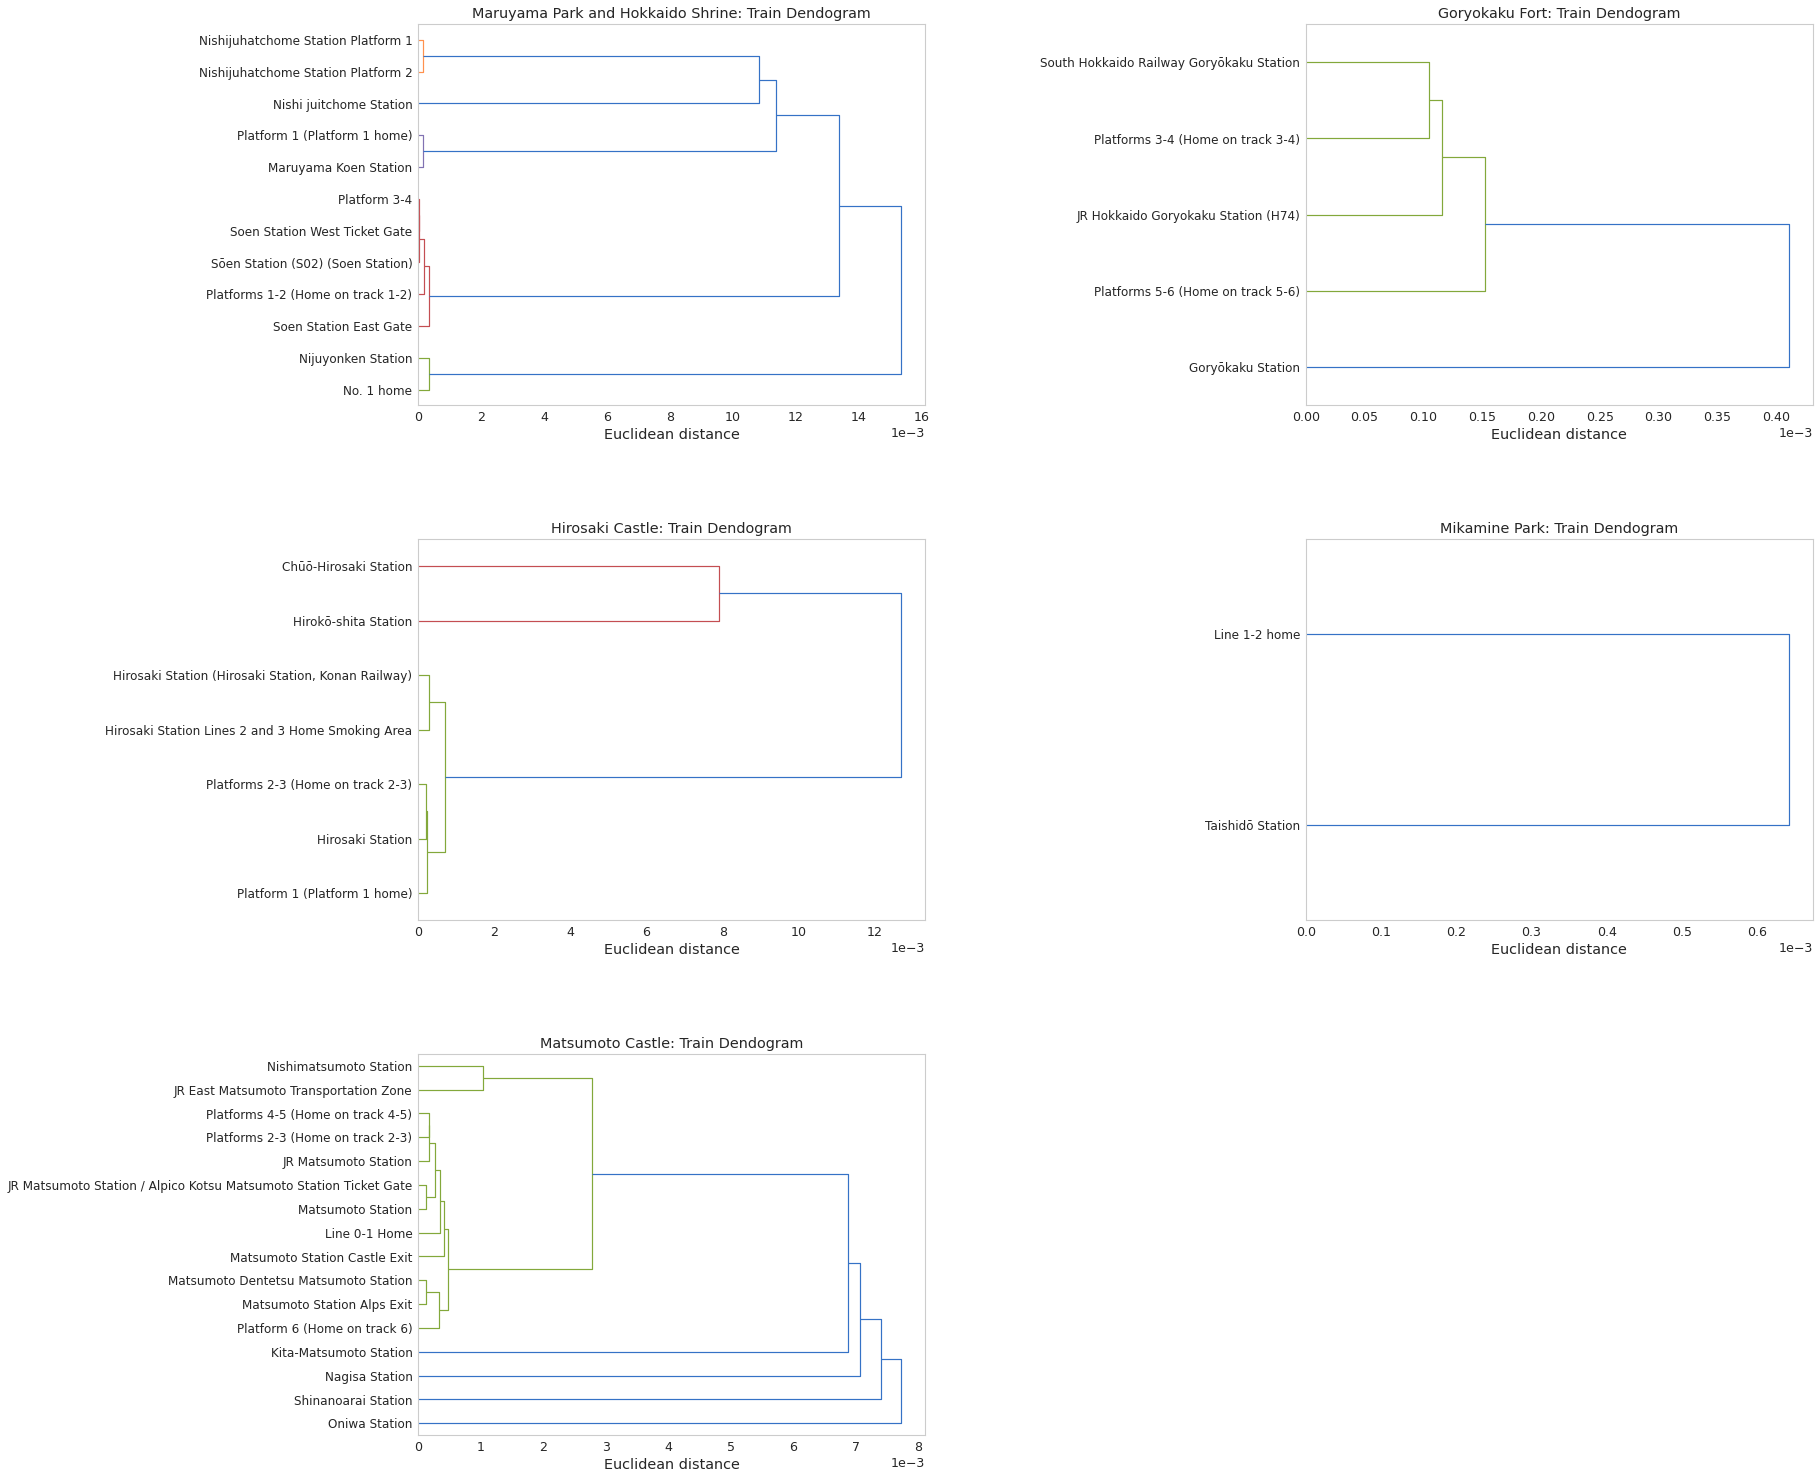

In [18]:
linkage = 'single'
generate_dendograms(trains_df,areaNames,linkage,(25,20),'ViewingSpots_dendogram')

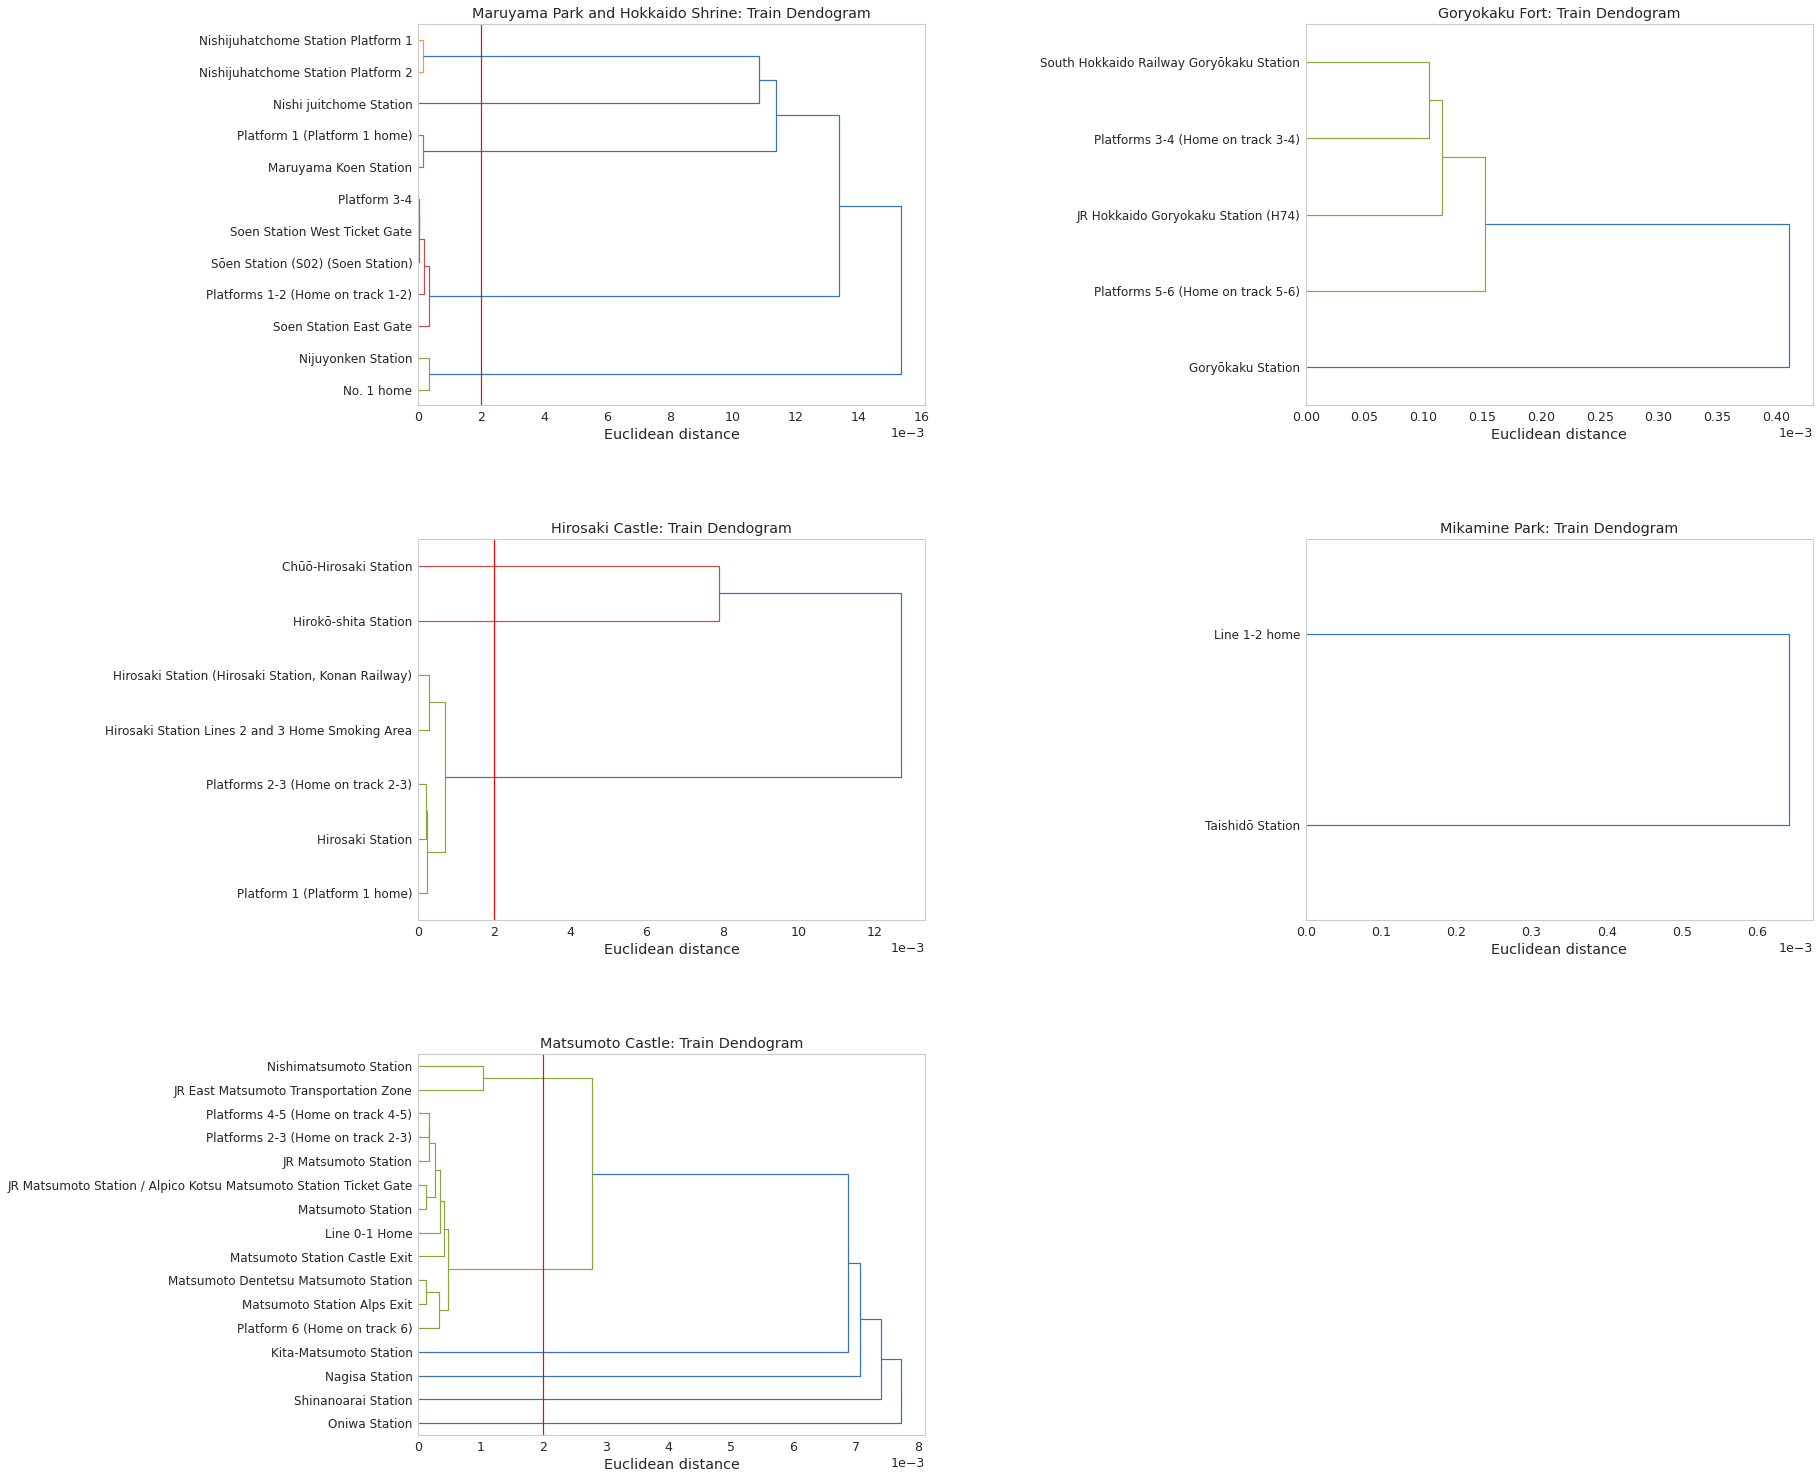

In [19]:
threshold = 0.002
generate_dendograms(trains_df,areaNames, linkage, (25,20),'ViewingSpots_dendogram_threshold', threshold = threshold)

We were looking to create clusters with a euclidean distance of at least `0.002` (~ 200meters / ~0.12 miles). The distance between the points at `Goryokaku Fort` and `Mikamine Park` are relatively small compared to the other three locations. It is for this reason those points in those areas will be one cluster.

* Maruyama Park and Hokkaido Shrine : 5 clusters
* Goryokaku Fort : 1 cluster
* Hirosaki Castle : 3 clusters
* Mikamine Park : 1 cluster
* Matsumoto Castle : 6 clusters

#### Agglomerative Clustering

With the number of clusters determined through the use of dendograms, we will now cluster all the train station venues based on cluster label for each of the recommended viewing spots.

The train station venues will be plotted. Those belonging to the same cluster will be in the same color and label based off their cluster label.

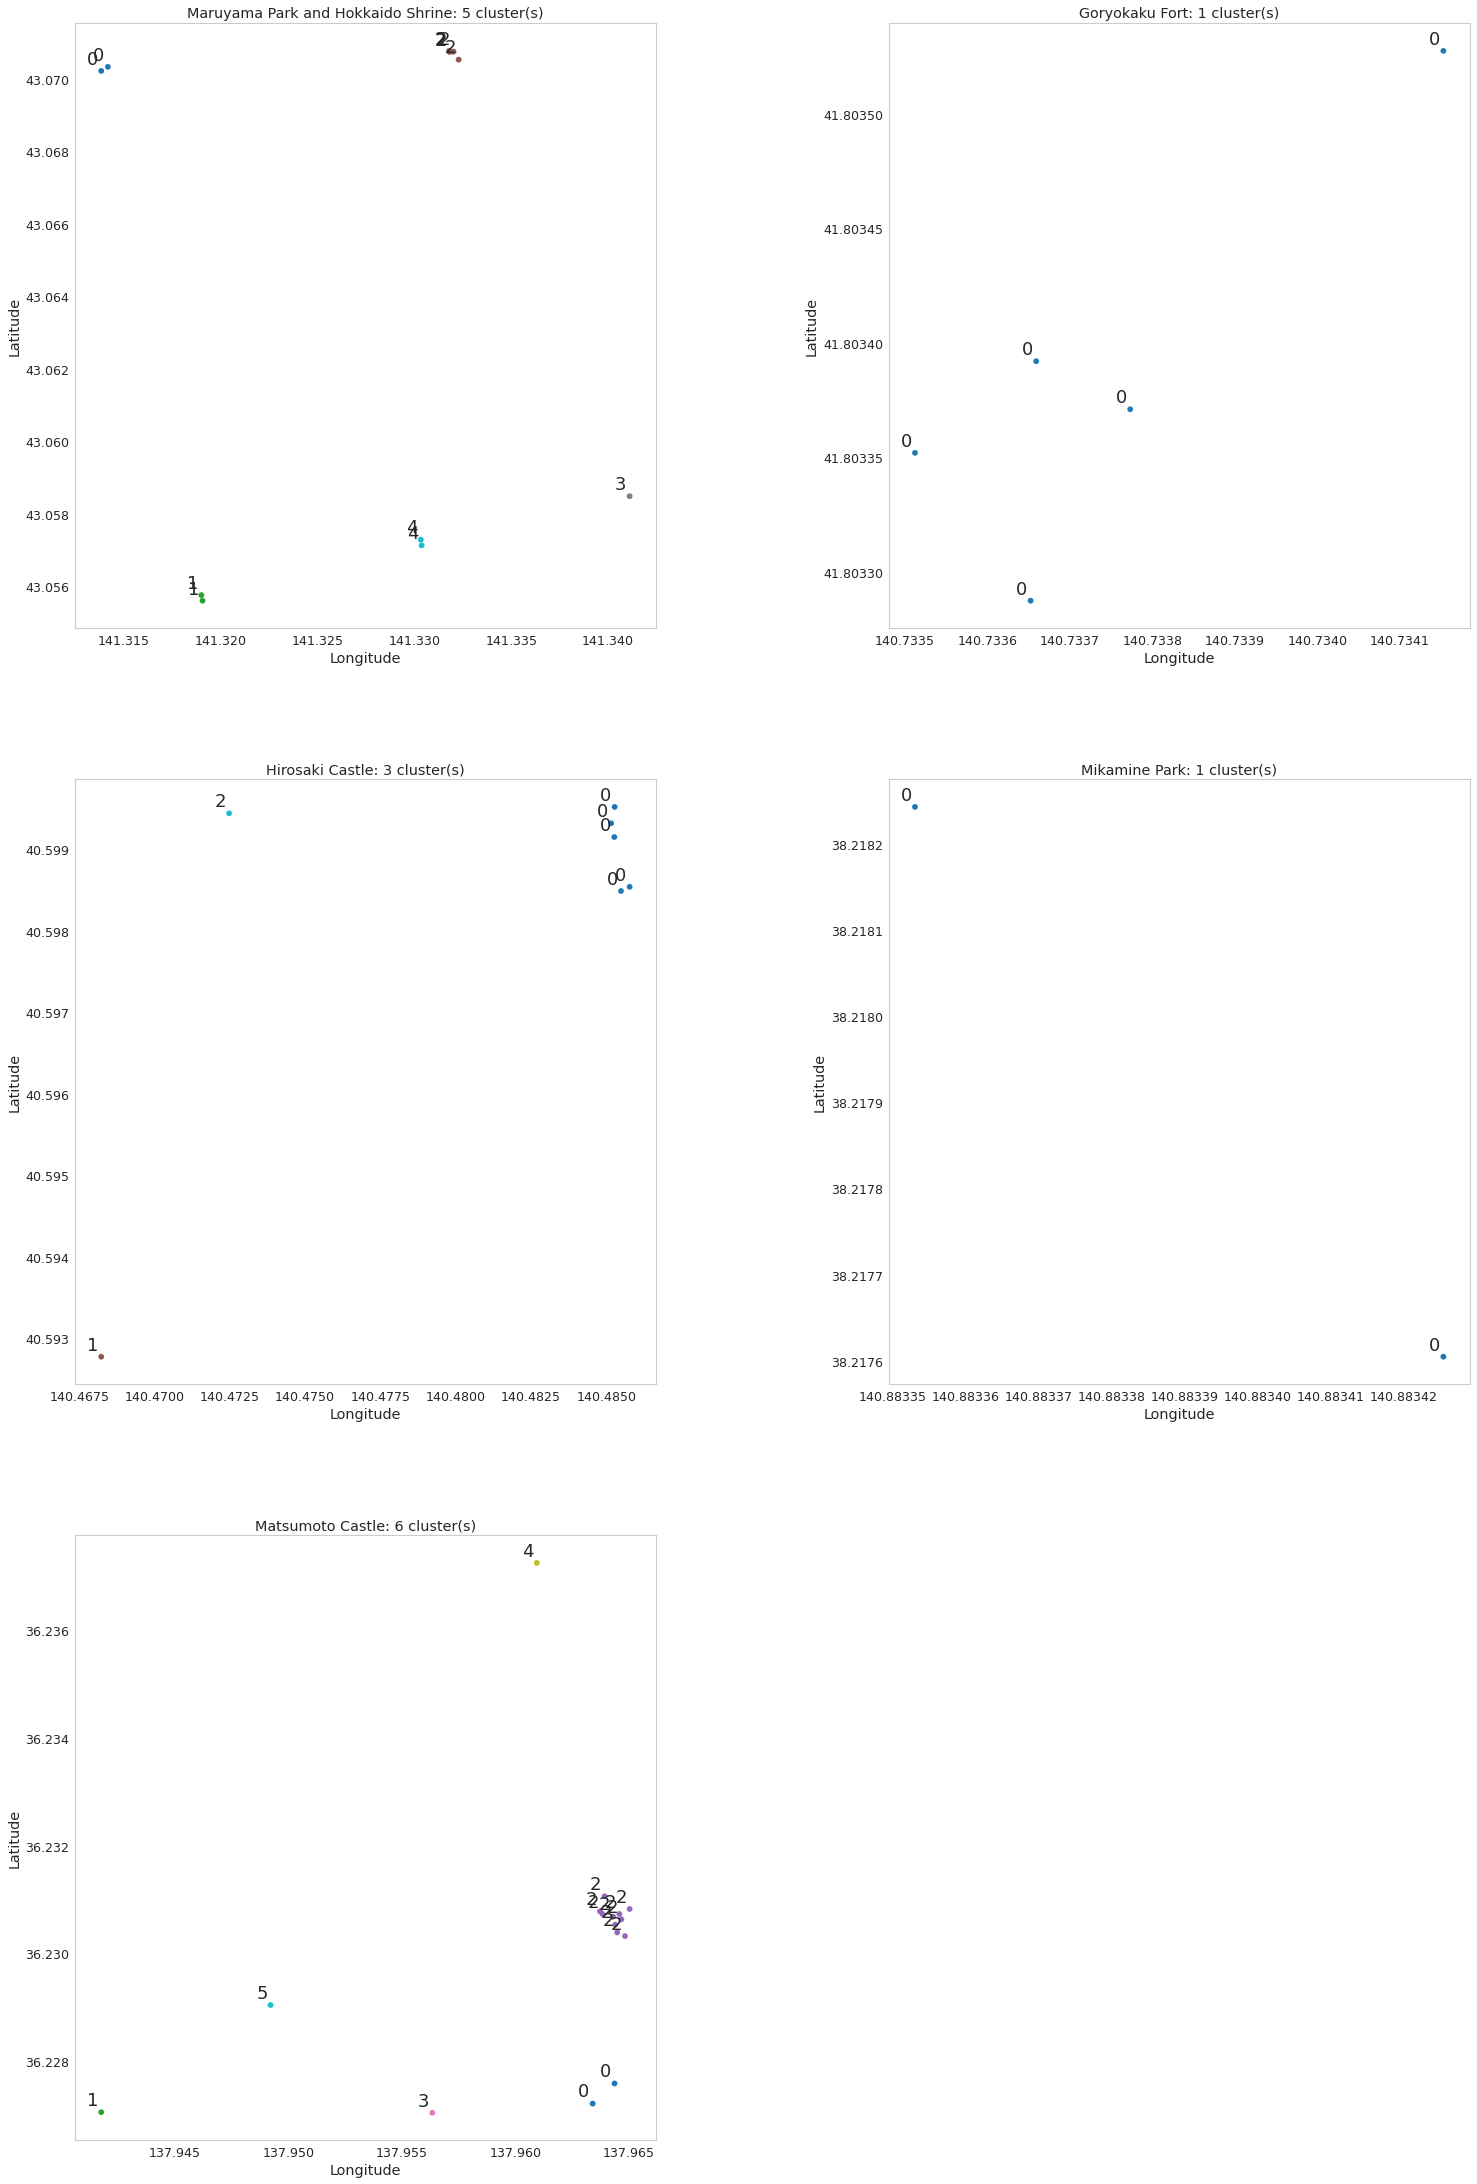

In [20]:
linkage ='single'
df_list = [] #list of dataframes for each viewing spot and surrounding train station info
k = [5,1,3,1,6]
plt.figure(figsize=(25, 30))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.25, wspace=0.4)

for i, name in enumerate(areaNames):
    plt.subplot(3,2,i+1)
    data_df = trains_df.loc[trains_df.VIEWING_SPOT.str.contains(name)]
    data = data_df.iloc[:,4:6].values 

    cluster = AgglomerativeClustering(n_clusters=k[i], affinity='euclidean', linkage= linkage)
    cluster.fit_predict(data)

    data_df.insert(0, 'CLUSTER', cluster.labels_) # associates cluster number to each train station 
    df_list.append(data_df) # appends a dataframe to a list
    
    plt.title(f'{areaNames[i]}: {k[i]} cluster(s)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.ticklabel_format(useOffset=False)
    plt.scatter(data[:,1],data[:,0], c= cluster.labels_,cmap ='tab10', label='True Position')
    
    
    for label, x, y in zip(cluster.labels_, data[:, 1], data[:, 0]):
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(-3, 3),
                     textcoords='offset points',
                     ha='right', va='bottom',
                     fontsize=18)
    
    plt.savefig(f'{imgFolder}Train_Clusters.png')

Now we will use the cluster labels to reduce the number of excess train station and platform points around a single venue. 

In [21]:
data_df.head(5)

,CLUSTER,VIEWING_SPOT,VIEWING_SPOT_LATITUDE,VIEWING_SPOT_LONGITUDE,VENUE,VENUE_LATITUDE,VENUE_LONGITUDE,DISTANCE_FROM_VIEWING_SPOT_METERS,VENUE_CATEGORY
177,2,Matsumoto Castle,36.238653,137.968867,Matsumoto Station,36.230638,137.964671,968,Train Station
184,4,Matsumoto Castle,36.238653,137.968867,Kita-Matsumoto Station,36.237255,137.960944,728,Train Station
186,2,Matsumoto Castle,36.238653,137.968867,JR Matsumoto Station / Alpico Kotsu Matsumoto Station Ticket Gate,36.230737,137.964582,961,Train Station
199,3,Matsumoto Castle,36.238653,137.968867,Nagisa Station,36.227047,137.956339,1713,Train Station
200,0,Matsumoto Castle,36.238653,137.968867,JR East Matsumoto Transportation Zone,36.227590,137.964370,1296,Train Station


In [22]:
# reduces excess train points by clusters into one point for each recommended viewing spot 
temp_dflist = []
for df in df_list:
    clusters = df.groupby('CLUSTER').mean()
      
    for icluster, cluster in clusters.iterrows():      
        names = list(df.loc[df.CLUSTER == icluster].VENUE)
        updated = {}
           
        names_list = []
        for name in names:         
            if 'Station' in name:       
                regex = re.compile('^.*(?=(Station))')
                new_name = f'{regex.search(name).group(0)}Station'                          
                break

        updated['VIEWING_SPOT'] = df.VIEWING_SPOT.unique()[0]
        updated['VIEWING_SPOT_LATITUDE'] = cluster.VIEWING_SPOT_LATITUDE
        updated['VIEWING_SPOT_LONGITUDE'] = cluster.VIEWING_SPOT_LONGITUDE
        updated['VENUE'] = new_name  
        updated['VENUE_LATITUDE'] = cluster.VENUE_LATITUDE
        updated['VENUE_LONGITUDE'] = cluster.VENUE_LONGITUDE
        updated['DISTANCE_FROM_VIEWING_SPOT_METERS'] = cluster.DISTANCE_FROM_VIEWING_SPOT_METERS
        updated['VENUE_CATEGORY'] = 'Train Station'  
        
        temp_dflist.append(updated)
    
    cols = ['VIEWING_SPOT','VIEWING_SPOT_LATITUDE','VIEWING_SPOT_LONGITUDE','VENUE','VENUE_LATITUDE','VENUE_LONGITUDE','DISTANCE_FROM_VIEWING_SPOT_METERS','VENUE_CATEGORY']    
    temp_df = pd.DataFrame(temp_dflist,columns = cols)
    
venues = venues.loc[venues.VENUE_CATEGORY.str.contains('Restaurant')]
venues = pd.concat([venues,temp_df])
venues = venues.sort_values(["VIEWING_SPOT","VENUE_CATEGORY"]).reset_index(drop=True)

print(f'Original Number of "Train Stations": {trains_df.shape[0]}.')
print(f'Current Number of "Train Stations": {temp_df.shape[0]}.')

Original Number of "Train Stations": 42.
Current Number of "Train Stations": 16.


#### Summary of clustering

42 `Train Station` and `Platform` points reduced to 16 `Train Station` points across the 5 recommended viewing spot areas.

With all the extra train station coordinates reduced around each of the viewing spots, the `venues` dataframe was updated to include the updated train station information with the old information removed.

### Plot venues around Recommended Viewing Spots
Plotting all the venues around each the viewing spots.

Restaurants will be indicated by a cutlery icon, while train stations will be indicated by a train icon.

In [23]:
# restaurant group of points
restaurant_df = venues.loc[venues.VENUE_CATEGORY.str.contains('Restaurant')].copy()
restaurant_icon = (0, 'cutlery', 'green', 'white',None, 'fa')

# train stations and platforms group of point
trains_df = venues.loc[~venues.VENUE_CATEGORY.str.contains('Restaurant')].copy()

figsize = (600, 400)

In [24]:
zoom = 13
zoomable = True
name = areaNames[0]

v_df = viewingSpot_df.loc[viewingSpot_df.VIEWING_SPOT == name]
center = (v_df.LATITUDE, v_df.LONGITUDE)
local_restaurants = restaurant_df.loc[restaurant_df.VIEWING_SPOT == name]
local_trains = trains_df.loc[trains_df.VIEWING_SPOT == name]

train_feature = ('Train Stations', local_trains, train_icon)
restaurant_feature = ('Ramen Shops', local_restaurants, restaurant_icon)
map_features = [restaurant_feature, train_feature]

generate_map(
    center,
    center[0],
    center[1],
    [name],
    zoom,
    zoomable,
    map_features = map_features,
    radius_circle = 2012,
    title = name,
    figsize = figsize,
    imgName = f'{name}_venues'
)

In [25]:
zoom = 13
zoomable = True
name = areaNames[1]

v_df = viewingSpot_df.loc[viewingSpot_df.VIEWING_SPOT == name]
center = (v_df.LATITUDE, v_df.LONGITUDE)
local_restaurants = restaurant_df.loc[restaurant_df.VIEWING_SPOT == name]
local_trains = trains_df.loc[trains_df.VIEWING_SPOT == name]

train_feature = ('Train Stations', local_trains, train_icon)
restaurant_feature = ('Ramen Shops', local_restaurants, restaurant_icon)
map_features = [restaurant_feature, train_feature]

generate_map(
    center,
    center[0],
    center[1],
    [name],
    zoom,
    zoomable,
    map_features = map_features,
    radius_circle = 2012,
    title = name,
    figsize = figsize,
    imgName = f'{name}_venues'
)

In [26]:
zoom = 13
zoomable = True
name = areaNames[2]

v_df = viewingSpot_df.loc[viewingSpot_df.VIEWING_SPOT == name]
center = (v_df.LATITUDE, v_df.LONGITUDE)
local_restaurants = restaurant_df.loc[restaurant_df.VIEWING_SPOT == name]
local_trains = trains_df.loc[trains_df.VIEWING_SPOT == name]

train_feature = ('Train Stations', local_trains, train_icon)
restaurant_feature = ('Ramen Shops', local_restaurants, restaurant_icon)
map_features = [restaurant_feature, train_feature]

generate_map(
    center,
    center[0],
    center[1],
    [name],
    zoom,
    zoomable,
    map_features = map_features,
    radius_circle = 2012,
    title = name,
    figsize = figsize,
    imgName = f'{name}_venues'
)

In [27]:
zoom = 13
zoomable = True
name = areaNames[3]

v_df = viewingSpot_df.loc[viewingSpot_df.VIEWING_SPOT == name]
center = (v_df.LATITUDE, v_df.LONGITUDE)
local_restaurants = restaurant_df.loc[restaurant_df.VIEWING_SPOT == name]
local_trains = trains_df.loc[trains_df.VIEWING_SPOT == name]

train_feature = ('Train Stations', local_trains, train_icon)
restaurant_feature = ('Ramen Shops', local_restaurants, restaurant_icon)
map_features = [restaurant_feature, train_feature]

generate_map(
    center,
    center[0],
    center[1],
    [name],
    zoom,
    zoomable,
    map_features = map_features,
    radius_circle = 2012,
    title = name,
    figsize = figsize,
    imgName = f'{name}_venues'
)

In [28]:
zoom = 13
zoomable = True
name = areaNames[4]

v_df = viewingSpot_df.loc[viewingSpot_df.VIEWING_SPOT == name]
center = (v_df.LATITUDE, v_df.LONGITUDE)
local_restaurants = restaurant_df.loc[restaurant_df.VIEWING_SPOT == name]
local_trains = trains_df.loc[trains_df.VIEWING_SPOT == name]

train_feature = ('Train Stations', local_trains, train_icon)
restaurant_feature = ('Ramen Shops', local_restaurants, restaurant_icon)
map_features = [restaurant_feature, train_feature]

generate_map(
    center,
    center[0],
    center[1],
    [name],
    zoom,
    zoomable,
    map_features = map_features,
    radius_circle = 2012,
    title = name,
    figsize = figsize,
    imgName = f'{name}_venues'
)

### Comparing the Recommended Viewing Spots 

Let's group rows by Viewing Spot and by taking the mean of the frequency of occurrence of each category


In [29]:
# one hot encoding
viewingSpot_onehot = pd.get_dummies(venues.VENUE_CATEGORY, prefix="", prefix_sep="")
# add Viewing_Spot column back to dataframe
viewingSpot_onehot['VIEWING_SPOT'] = venues.VIEWING_SPOT 

# # move Viewing Spot column to the first column
fixed_columns = [viewingSpot_onehot.columns[-1]] + list(viewingSpot_onehot.columns[:-1])
viewingSpot_onehot = viewingSpot_onehot[fixed_columns]

viewingSpot_grouped = viewingSpot_onehot.groupby('VIEWING_SPOT').mean().reset_index()
# print("viewingSpot_grouped new size: ", viewingSpot_grouped.shape)
viewingSpot_grouped.head()

,VIEWING_SPOT,Ramen Restaurant,Train Station
0,Goryokaku Fort,0.976744,0.023256
1,Hirosaki Castle,0.923077,0.076923
2,Maruyama Park and Hokkaido Shrine,0.883721,0.116279
3,Matsumoto Castle,0.850000,0.150000
4,Mikamine Park,0.970588,0.029412


Not very informative due to only two types of venues.

Let's look at how each of the viewing spots compare to one another in regards to Ramen Restaurants and Train Stations.

We will do this through the use of a bar charts.

First, let's see how the number of Ramen Restaurants and Train Stations compare.

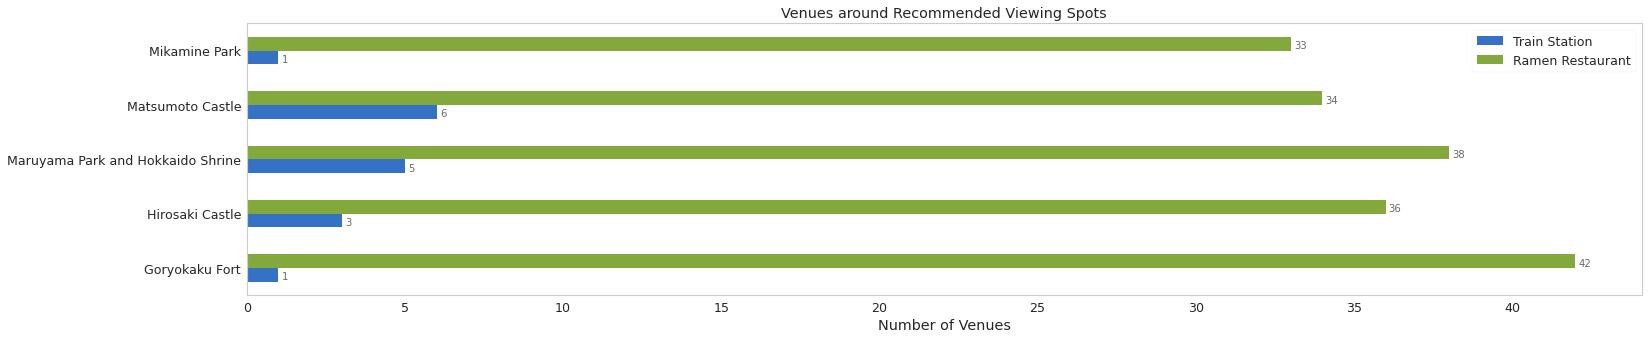

In [30]:
data_r = restaurant_df.groupby('VIEWING_SPOT').count().VENUE
data_t = trains_df.groupby('VIEWING_SPOT').count().VENUE
data = pd.DataFrame({'Train Stations': data_t, 'Ramen Restaurants': data_r},index=data_r.index)

ax = data.plot.barh(figsize=(25,5))
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.04, \
            str(round((i.get_width()), 2)), fontsize=10, color='dimgrey')

ax.legend(["Train Station", "Ramen Restaurant"], loc='best')
plt.title('Venues around Recommended Viewing Spots')
plt.ylabel('')
plt.xlabel('Number of Venues')

plt.savefig(f'{imgFolder}Venue_Count.png')
plt.show()

Next, let's see the average distance to Ramen Restaurants and Train Stations.

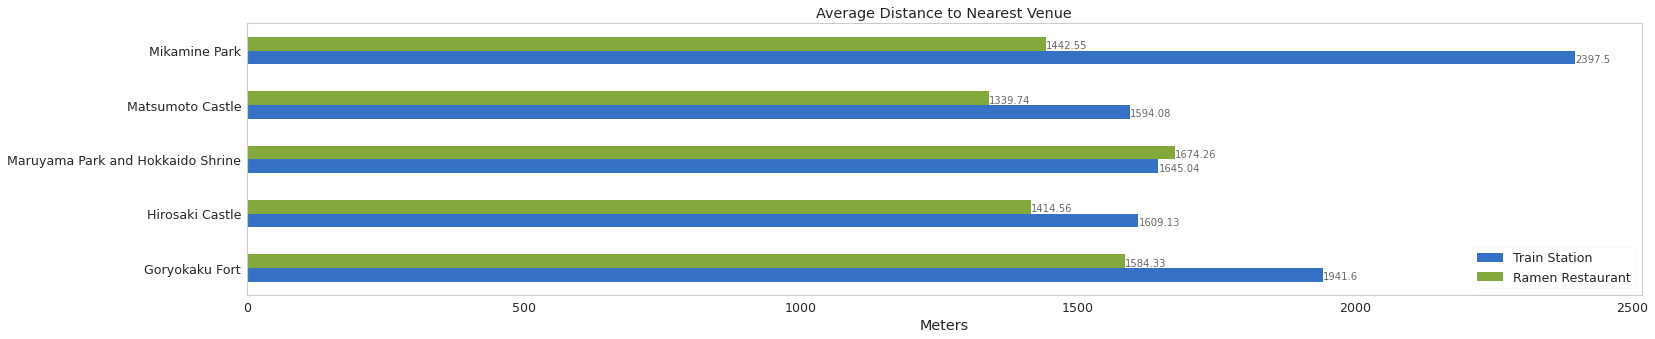

In [31]:
data_r = restaurant_df.groupby('VIEWING_SPOT').mean().DISTANCE_FROM_VIEWING_SPOT_METERS
data_t = trains_df.groupby('VIEWING_SPOT').mean().DISTANCE_FROM_VIEWING_SPOT_METERS
data = pd.DataFrame({'Train Stations': data_t, 'Ramen Restaurants': data_r},index=data_r.index)

ax = data.plot.barh(figsize=(25,5))
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.04, \
            str(round((i.get_width()), 2)), fontsize=10, color='dimgrey')

ax.legend(["Train Station", "Ramen Restaurant"], loc='best')
plt.title('Average Distance to Nearest Venue')
plt.ylabel('')
plt.xlabel('Meters')

plt.savefig(f'{imgFolder}Average_Venue_Distance.png')
plt.show()

## Results and Discussion  <a name="results"></a>




From the many Hanami spots across Japan, five Hanami spots (Mikamine Park, Matsumoto Castle, Maruyama Park and Hokkaido Shrine, Hirosaki Castle, and Goryokaku Fort) were selected based off average cherry blossoming time occurring between April 15th - May 15th and based off recommendations from  [https://www.japan-guide.com/e/e2011_where.html](https://www.japan-guide.com/e/e2011_where.html). Our analysis of these five recommended Hanami spots showed there are a quite a number of Ramen Shops/Restaurants and at least one train station around each location.

Now, how can we determine which of the five recommended Hanami Spots should be selected as the "best".  The criteria that will be used are: 1) Ramen shops located close to the recommended Hanami spots and 2) Proximity to a train station.

1) Ramen Shops 

    We can quickly compare the number of Ramen Shops between each of the five Hanami Spots by looking at Chart A. Based off number of Ramen shops alone, Goryokaku Fort is the best of the recommended Hanami Spots with 42 Ramen Shops and Mikamine Park is the "worst" with only 33 Ramen Shops within a 1.25 mile radius. Furthermore looking at Chart B, the best Hanami Spot would be Matsumoto Castle with a Ramen Shop located within an average distance of \~1340 meters (\~0.83 miles) and the "worst" location would be Maruyama Park and Hokkaido Shrine with a Ramen Shop located within an average distance of \~1674 meters (\~1.04 miles). 

2) Train Stations

    Chart B indicates Matsumoto Castle would be the best location to enjoy Hanami and grab a train due to the average distance to a train station is \~1594 meters with six train stations in the area. While Mikamine Park is the "worst" with an average distance of \~2398 meters with only the one train station in the area.
    
Another criterion to select the "best" Hanami spot is to use the rating system found at [https://www.japan-guide.com/e/e2011_where.html](https://www.japan-guide.com/e/e2011_where.html). The rating for each of the recommended Hanami spots were also scraped from the site and can found within the `viewingSpot_df` dataframe. The ratings range from 1 to 3 where the numbers represent the following: 

1) Recommended

2) Highly Recommended

3) Best of Japan


In [32]:
viewingSpot_df.sort_values('RATING',ascending=False)

,VIEWING_SPOT,AVERAGE_OPENING,AVERAGE_FULL_BLOOM,CITY,PREFECTURE,REGION,LATITUDE,LONGITUDE,DESCRIPTION,RATING,RATING_DESCRIPTION
2,Hirosaki Castle,April 23,April 28,Hirosaki,Aomori,Tohoku,40.607452,140.464180,"With its abundance of over 2500 trees, cherry blossom tunnels, petal filled moats, numerous pleasant picnic areas, rental rowing boats, many varieties of cherry trees and illuminations in the evenings, the park around Hirosaki Castle feels like multiple great cherry blossom spots combined into a single one.",3,Best of Japan
1,Goryokaku Fort,April 30,May 4,Hakodate,Hokkaido,Hokkaido,41.794670,140.754020,"Fort Goryokaku is a star shaped, Western style citadel which was built in Hakodate towards the end of the Edo Period. After the fort lost its military importance, it was eventually turned into a public park, and over one thousand cherry trees were planted along its moats, making it arguably Hokkaido's most famous cherry blossom spot.",2,Highly Recommended
4,Matsumoto Castle,April 10,April 15,Matsumoto,Nagano,Chubu,36.238653,137.968867,Matsumoto Castle is one of the most beautiful of Japan's original castles. There are about 300 cherry trees planted around the castle moats and inside the paid inner grounds of the castle.,2,Highly Recommended
0,Maruyama Park and Hokkaido Shrine,May 3,May 7,Sapporo,Hokkaido,Hokkaido,43.055745,141.312607,"The park and the shrine are located just beside each other and attract some of the largest crowds for hanami parties in Sapporo. The approach to the shrine is lined with dozens of cherry trees, while the park areas offer a lot of open space where people lay out mats and enjoy food and drink with friends under the flowers.",1,Recommended
3,Mikamine Park,April 11,April 16,Sendai,Miyagi,Tohoku,38.224822,140.857414,"Located south of central Sendai, Mikamine Park is a spacious public park with hundreds of large, beautiful cherry trees and wide lawns, offering plenty of space to hold cherry blossom viewing parties underneath its cherry trees.",1,Recommended


Based off the rating system, Hirosaki Castle is the best Hanami Spot from the bunch to visit. Not only is it considered a "Best of Japan" location, it has 36 Ramen Shops within an average distance of \~1415 meters (\~ 0.88 miles) and 3 Trains stations within an average distance of  \~1609 meters (~ 1.0 mile). 

## Conclusion <a name="conclusion"></a>

In this project, we identified some of the best locations in Japan in which to enjoy both Hanami and Ramen from April 15th to May 15th. We found locations which could be traveled to easily based on the proximity of train stations. Also we found that each of the recommended Hanami spots have a good number of choices for Ramen Shops located nearby. 

We also looked at how to cluster multiple venue coordinates together for a single train station located within a small area through the use of Hierarchical clustering. The ability to quickly compare the number of venues around each of the recommended Hanami Spots was accomplished through the use of bar charts.

Overall, there are many different locations a person can visit to enjoy springtime and the cherry blossoms in Japan. The biggest factor to keep in mind is the when. With cherry blossoms lasting a short time span and the cherry blossom front traveling from south to north, a person needs to keep the time of year in mind when planning a trip to Japan to experience the tradition of Hanami.